In [38]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy import control as ctrl
import random

In [39]:
PATH = './AMAZON_FASHION.json.gz'
PATH_meta = './meta_AMAZON_FASHION.json.gz'

## MODULO 1
### Lector de datasets

In [40]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [41]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [42]:
df_meta.shape

(186637, 16)

In [43]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [44]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

Text(0, 0.5, 'Count')

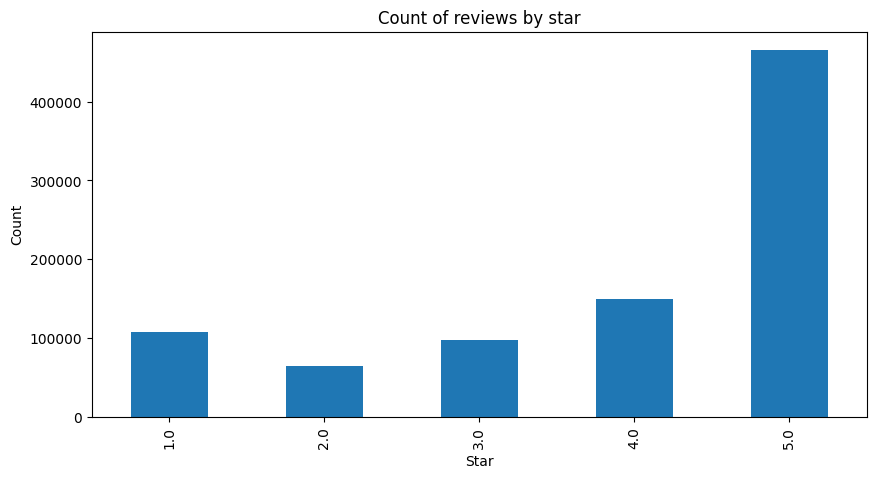

In [45]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")

notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [46]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## MODULO 2
### Rating Score
calculamos el overall mean

In [47]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


agregamos la columnas id al dataframe df_meta

In [48]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos la muestra para facilitar el procesamiento 

In [49]:
CANTIDAD = 10000

In [50]:
df_meta_cortado = df_meta.head(CANTIDAD)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [51]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_meta_cortadoFrame 'df_meta_cortado'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


C:\Users\coraj\AppData\Local\Temp\ipykernel_20708\1163952785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


La matriz vecs contiene las puntuaciones TF-IDF ( Frecuencia de Término - Frecuencia Inversa de Documento) para cada palabra en cada documento. Las puntuaciones TF-IDF representan la importancia de una palabra para un documento en la colección.

In [52]:

vec = TfidfVectorizer()
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(10000, 22929)

## Modulo 3
### Similarity Score

Esto significa que tienes 10000 documentos (las filas del DataFrame df_meta_cortado) y 22929 palabras únicas en todos los documentos (las características).

calcular la similitud del coseno entre cada par de vectores en vecs

Su valor varía de -1 (vectores completamente opuestos) a 1 (vectores idénticos), con 0 indicando ortogonalidad (vectores perpendiculares).

In [53]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.00388052, 0.039671  , ..., 0.00938346, 0.00938346,
        0.00179705],
       [0.00388052, 1.        , 0.        , ..., 0.        , 0.        ,
        0.00467325],
       [0.039671  , 0.        , 1.        , ..., 0.1177269 , 0.1177269 ,
        0.        ],
       ...,
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00179705, 0.00467325, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [54]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    # scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

### Seleccionamos 4 productos aleatorios

In [55]:
# Inicializa listas vacías para almacenar los resultados
asins_resultados = []
similaridad_score_resultados = []
random_asin_valores= []

# Lista de asins únicos del DataFrame df_meta_cortado
asins_unicos = df_meta_cortado['asin'].unique()

# Realiza 4 recomendaciones con valores aleatorios
for i in range(4):
    random_asin = random.choice(asins_unicos)
    print(random_asin)
    asins, similaridad_score = recommend(random_asin)
    # Agrega los resultados a las listas
    asins_resultados.append(asins)
    similaridad_score_resultados.append(similaridad_score)
    random_asin_valores.append(random_asin)


B0046JPQ28
B003R8CQUO
B0009815P2
B000FLEMAS


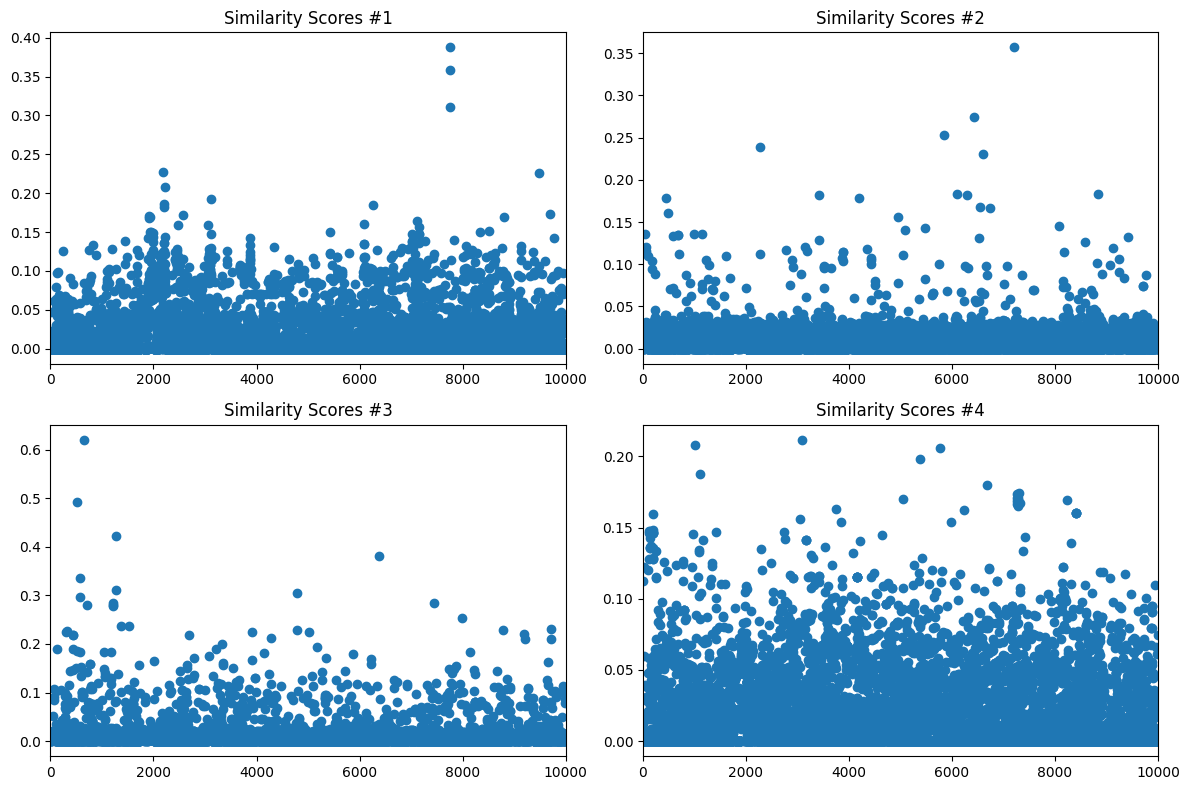

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterar a través de los 4 resultados y graficarlos en subplots separados
for i in range(4):
    scores_df = pd.DataFrame(similaridad_score_resultados[i], columns=['ItemID', 'Score'])
    ax = axs[i // 2, i % 2]  # Seleccionar el subplot adecuado
    ax.scatter(scores_df['ItemID'], scores_df['Score'])
    ax.set_title(f'Similarity Scores #{i+1}')
    ax.set_xlim(0, 10000)

plt.tight_layout()
plt.show()


In [57]:
# Inicializa listas vacías para almacenar los resultados
final_results = []
# Itera a través de los 4 conjuntos de resultados
for producto in range(4):
    top_scores_product = [similarity_score[1] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_item_ids_product = [similarity_score[0] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_asin_product = asins_resultados[producto][:CANTIDAD]

    # Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
    data = list(zip(top_asin_product, top_scores_product, top_item_ids_product))

    # Crear un DataFrame a partir de los datos combinados
    df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

    # Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
    final_result = pd.merge(df_result, overall_mean, on='asin')
    print(final_result)
    final_results.append(final_result)



            asin     Score    Id  overall
0     B0046JPNAS  0.387528  7753      2.0
1     B0046JROIW  0.358467  7754      4.0
2     B0046JNEZY  0.310789  7752      5.0
3     B000J4J34Q  0.227093  2190      1.0
4     B0050Z26XY  0.225830  9485      2.5
...          ...       ...   ...      ...
9994  B00591YLEG  0.000000  9995      5.0
9995  B00591XGD8  0.000000  9996      5.0
9996  B00591VVDA  0.000000  9997      3.0
9997  B00591YFH4  0.000000  9998      4.0
9998  B00592SB5A  0.000000  9999      3.0

[9999 rows x 4 columns]
            asin     Score    Id  overall
0     B003RBI5YM  0.356802  7210      5.0
1     B002YP9ZCS  0.274255  6435      2.0
2     B002EK9QOA  0.253394  5841      4.0
3     B000JIQTQM  0.238761  2277      2.0
4     B0035YG0WA  0.230271  6607      5.0
...          ...       ...   ...      ...
9993  B00591PC62  0.000000  9994      3.8
9994  B00591YLEG  0.000000  9995      5.0
9995  B00591XGD8  0.000000  9996      5.0
9996  B00591VVDA  0.000000  9997      3.0
9997  B00

## MODULO 4
### Sistema de inferencia difuso

In [58]:
# Definimos las variables de entrada y salida para el sistema de control difuso
overall = ctrl.Antecedent(np.arange(1, 6, 0.1), 'overall')  # Calificación general
similaridad = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'similaridad')  # Similaridad con otros elementos
recomendacion = ctrl.Consequent(np.arange(0, 2, 0.1), 'recomendacion')  # Recomendación resultante

# Definimos los trapecios para las variables de entrada y salida
overall['excelente'] = fuzz.trapmf(overall.universe, [4.1, 5, 5, 5]) # si el valor es [4.1 o 5], entonces es excelente
overall['bueno'] = fuzz.trapmf(overall.universe, [3.1, 4, 4, 4.1]) # si el valor es [3.1 o 4.1), entonces es bueno
overall['normal'] = fuzz.trapmf(overall.universe, [2.1, 3, 3, 3.1]) # si el valor es [2.1 o 3.1), entonces es normal
overall['pesimo'] = fuzz.trapmf(overall.universe, [0.99, 2, 2, 2.1]) # si el valor es (0.99 o 2.1), entonces es pesimo

similaridad['muy_similar'] = fuzz.trapmf(similaridad.universe, [0.7, 1, 1, 1]) # si el valor es [0.7 o 1], entonces es muy similar
similaridad['similar'] = fuzz.trapmf(similaridad.universe, [0.4, 0.7, 0.7, 0.7]) # si el valor es [0.4 o 0.7), entonces es similar
similaridad['poco_similar'] = fuzz.trapmf(similaridad.universe, [0.2, 0.4, 0.4, 0.4]) # si el valor es [0.2 o 0.4), entonces es poco similar
similaridad['no_similar'] = fuzz.trapmf(similaridad.universe, [-1, 0, 0, 0.2])  # si el valor es [-1 o 0.2), entonces es no similar


recomendacion['muy_recomendado'] = fuzz.trapmf(recomendacion.universe, [1.1, 2, 2, 2]) # si el valor es [1.1 o 2], entonces es muy recomendado
recomendacion['recomendado'] = fuzz.trapmf(recomendacion.universe, [0.1, 1, 1, 1.1]) # si el valor es [0.1 o 1.1), entonces es recomendado
recomendacion['no_recomendado'] = fuzz.trapmf(recomendacion.universe, [0, 0, 0, 0.1]) # si el valor es [0 o 0.1), entonces es no recomendado

# regla 1: si la similaridad es no similar y el overall es excelente, bueno, normal o pesimo, entonces la recomendacion es no recomendado
rule1 = ctrl.Rule(similaridad['no_similar'] & (overall['excelente'] | overall['bueno'] | overall['normal'] | overall['pesimo']), recomendacion['no_recomendado'])
# regla 2: si la similaridad es muy similar, similar, poco similar o no similar y el overall es pesimo, entonces la recomendacion es no recomendado
rule2 = ctrl.Rule(overall['pesimo'] & (similaridad['muy_similar'] | similaridad['similar'] | similaridad['poco_similar'] | similaridad['no_similar']), recomendacion['no_recomendado'])
# regla 3: si la similaridad es muy similar o similar y el overall es excelente o bueno, entonces la recomendacion es muy recomendado
rule3 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['muy_recomendado'])
# regla 4: si la similaridad es muy similar o similar y el overall es normal, entonces la recomendacion es recomendado
rule4 = ctrl.Rule(overall['normal']  & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['recomendado'])
# regla 5: si la similaridad es muy similar o similar y el overall es excelente o bueno y poco similar, entonces la recomendacion es recomendado
rule5 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['poco_similar']), recomendacion['recomendado'])
# regla 6: si la similaridad es poco similar y el overall es normal, entonces la recomendacion es no recomendado
rule6 = ctrl.Rule(overall['normal'] & similaridad['poco_similar'], recomendacion['no_recomendado'])

# Sistema de control y simulación
sistema_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_simulacion = ctrl.ControlSystemSimulation(sistema_control)

testeamos

In [59]:
# Pasar entradas al sistema
sistema_simulacion.input['overall'] = 4  # Ejemplo de calificación
sistema_simulacion.input['similaridad'] = 0.7  # Ejemplo de calificación
sistema_simulacion.compute() # Defuzzificación

# Por el metodo 'centroide'
print(sistema_simulacion.output['recomendacion'])

1.6333333333333335


## MODULO 5
### Defusificador

Defuzzificamos el resultado

In [60]:
def sistema_recomendacion_defuzzificado (recomendacion):
    if recomendacion < 0.1:
        return 'no_recomendado'
    elif recomendacion < 1.1:
        return 'recomendado'
    else:
        return 'muy_recomendado'
    

In [61]:
def sistema_recomendacion( similarity, overall):
    sistema_simulacion.input['overall'] = overall  # Ejemplo de calificación
    sistema_simulacion.input['similaridad'] = similarity # Ejemplo de calificación
    sistema_simulacion.compute() # Defuzzificación
    return (sistema_recomendacion_defuzzificado(sistema_simulacion.output['recomendacion']),sistema_simulacion.output['recomendacion'] )

In [62]:
# Itera a través de los 4 conjuntos de resultados

for i in range(4):
   # Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
    final_results[i]['result'] = final_results[i].apply(lambda row: sistema_recomendacion(row['Score'], row['overall']), axis=1) 

# Para mostrar el DataFrame resultante
for i, df_result in enumerate(final_results):
    print(f"Resultados para conjunto {i + 1}: con asin ", random_asin_valores[i])
    sorted_results = final_results[i].sort_values(by='result', key=lambda x: x.apply(lambda y: y[1] if isinstance(y, tuple) else y), ascending=False)
    print(sorted_results['result'])
    print()



Resultados para conjunto 1: con asin  B0046JPQ28
1            (recomendado, 0.7238110043648358)
2            (recomendado, 0.5995902838747502)
7208    (no_recomendado, 0.049999999999999115)
2573    (no_recomendado, 0.049999999999999115)
1218    (no_recomendado, 0.049999999999999115)
                         ...                  
6132     (no_recomendado, 0.03333333333333333)
6135     (no_recomendado, 0.03333333333333333)
6136     (no_recomendado, 0.03333333333333333)
8664     (no_recomendado, 0.03333333333333333)
9998     (no_recomendado, 0.03333333333333333)
Name: result, Length: 9999, dtype: object

Resultados para conjunto 2: con asin  B003R8CQUO
2            (recomendado, 0.6506519320100552)
0            (recomendado, 0.5995902838747502)
4            (recomendado, 0.5979797413792955)
4745    (no_recomendado, 0.049999999999999115)
3002    (no_recomendado, 0.049999999999999115)
                         ...                  
8687     (no_recomendado, 0.03333333333333333)
8686     (no_

In [69]:
from IPython.display import display

for i in range(4):
    producto_encontrado = df_meta_cortado.loc[df_meta_cortado['asin'] == random_asin_valores[i]] 
    print("Producto seleccionado: ")
    display(producto_encontrado)
    resultado_completo = pd.merge(final_results[i], df_meta_cortado, on='asin')
    print("Productos recomendados:")
    display(resultado_completo.head(5))


Producto seleccionado: 


,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
8199,221 Kerkraam Earrings Organic / Silver Jewelry...,BalineseOrganics,[Package Dimensions:\n \n3....,"25,760,267inClothing,ShoesJewelry(",BalineseOrganics,B0046JPQ28,NaN,NaN,[Earrings - Height - 3cm / Width 1.8cm - 92.5...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7755,221 Kerkraam Earrings Organic / Silver Jewelry...


Productos recomendados:


,asin,Score,Id,overall,result,title,brand,feature,rank,date,...,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
0,B0046JPNAS,0.387528,7753,2.0,"(no_recomendado, 0.033455356791760836)",282 Twin Fates Pendant Organic / Silver Jewelr...,BalineseOrganics,[Package Dimensions:\n \n3....,"24,808,600inClothing,ShoesJewelry(",BalineseOrganics,...,[Pendant -Height - 3.5cm / Width - 1.7cm - 92...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7753,282 Twin Fates Pendant Organic / Silver Jewelr...
1,B0046JROIW,0.358467,7754,4.0,"(recomendado, 0.7238110043648358)",204 Kupu-Kupu Earrings Organic / Silver Jewelr...,BalineseOrganics,[Package Dimensions:\n \n3....,"25,775,837inClothing,ShoesJewelry(",BalineseOrganics,...,[Earrings / 92.5 silver / Healing amethist sto...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7754,204 Kupu-Kupu Earrings Organic / Silver Jewelr...
2,B0046JNEZY,0.310789,7752,5.0,"(recomendado, 0.5995902838747502)",263 Bone Skull Pendant Organic / Silver Jewelr...,BalineseOrganics,[Package Dimensions:\n \n3....,"24,662,980inClothing,ShoesJewelry(",BalineseOrganics,...,[Pendant - Hand-Carved Water Buffalo Bone / 92...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752,263 Bone Skull Pendant Organic / Silver Jewelr...
3,B000J4J34Q,0.227093,2190,1.0,"(no_recomendado, 0.04975288573633482)",Silver Vintage style Bali Flower Earrings,SilverSpeck.com,NaN,"23,883,698inClothing,ShoesJewelry(",SilverSpeck.com,...,[Two metals give mesmerizing beauty to these v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190,Silver Vintage style Bali Flower Earrings Silv...
4,B0050Z26XY,0.225830,9485,2.5,"(no_recomendado, 0.04684559507821806)",Sterling Silver Bali Inspired Semi Hoop Post E...,NaN,NaN,"19,067,518inClothing,ShoesJewelry(",5 star5 star (0%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9485,Sterling Silver Bali Inspired Semi Hoop Post E...


Producto seleccionado: 


,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
7647,Caribbean Joe Madeline Rolling Fashion Travel ...,NaN,NaN,"23,751,585inClothing,ShoesJewelry(",5 star5 star (0%),B003R8CQUO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7203,Caribbean Joe Madeline Rolling Fashion Travel ...


Productos recomendados:


,asin,Score,Id,overall,result,title,brand,feature,rank,date,...,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
0,B003RBI5YM,0.356802,7210,5.0,"(recomendado, 0.5995902838747502)","Caribbean Joe Malibu 21"" Hardshell Spinner Car...",NaN,NaN,"24,035,847inClothing,ShoesJewelry(",5 star,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7210,"Caribbean Joe Malibu 21"" Hardshell Spinner Car..."
1,B002YP9ZCS,0.274255,6435,2.0,"(no_recomendado, 0.04142337038042921)",G.I. Joe The Rise Of Cobra Boy's Winter Hat & ...,G. I. Joe,NaN,"8,237,967inClothing,ShoesJewelry(",5 star5 star (0%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6435,G.I. Joe The Rise Of Cobra Boy's Winter Hat & ...
2,B002EK9QOA,0.253394,5841,4.0,"(recomendado, 0.6506519320100552)",Roxy aurora satchel - Black,NaN,NaN,"25,794,928inClothing,ShoesJewelry(",5 star5 star (0%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5841,Roxy aurora satchel - Black nan nan
3,B000JIQTQM,0.238761,2277,2.0,"(no_recomendado, 0.04532817136732941)",Leather Backpack and Rolling Bag - Rolling Car...,Winning Gifts,NaN,"24,586,340inClothing,ShoesJewelry(",5 star5 star (0%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2277,Leather Backpack and Rolling Bag - Rolling Car...
4,B0035YG0WA,0.230271,6607,5.0,"(recomendado, 0.5979797413792955)",Rolling Stones - Mens Rolling Stones - Logo Kn...,Old Glory,NaN,"18,479,646inClothing,ShoesJewelry(",5 star,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6607,Rolling Stones - Mens Rolling Stones - Logo Kn...


Producto seleccionado: 


,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
1205,4-Pack Classic Cuffs Baby Socks,Playskool,NaN,NaN,5 star,B0009815P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,762,4-Pack Classic Cuffs Baby Socks Playskool nan


Productos recomendados:


,asin,Score,Id,overall,result,title,brand,feature,rank,date,...,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
0,B0007LXT8W,0.619856,651,2.000000,"(no_recomendado, 0.035210722601536425)",8-Pack Triple Cuff Socks,Playskool,NaN,NaN,5 star5 star (0%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,651,8-Pack Triple Cuff Socks Playskool nan
1,B00069SS7C,0.492882,520,2.333333,"(recomendado, 0.6315325241900996)",5-Pack Bodysuits (Bright),Playskool,NaN,NaN,5 star,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520,5-Pack Bodysuits (Bright) Playskool nan
2,B000EP3H3S,0.422774,1281,4.000000,"(recomendado, 0.8088860016964334)",6-Pack Classic Cuffs Baby Socks,NaN,[Shipping Weight:\n \n4 oun...,NaN,5 star5 star (0%),...,[Luvable Friends 6-Pack Classic cuffs are a cu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1281,"6-Pack Classic Cuffs Baby Socks nan [""Luvable ..."
3,B002X34WUG,0.380599,6377,4.666667,"(recomendado, 0.7066399733066399)",Funky Socks 2 Pack - Mens Socks - Casual Socks...,Funky Socks,[Product Dimensions:\n \n11...,"1,124,866inClothing,ShoesJewelry(",5 star,...,NaN,NaN,NaN,[B00LU35X6C],NaN,NaN,NaN,NaN,6377,Funky Socks 2 Pack - Mens Socks - Casual Socks...
4,B0006N4YDA,0.335645,567,4.000000,"(recomendado, 0.7124445897111549)",6-Pack Cushion and Crew Socks,NaN,NaN,NaN,5 star5 star (0%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,567,6-Pack Cushion and Crew Socks nan nan


Producto seleccionado: 


,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
1868,IP24 Image Plate,Konad,NaN,"25,756,916inClothing,Shoesamp;Jewelry(",5 star,B000FLEMAS,NaN,NaN,[For use with our Nail Stamping System. 7 des...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1425,IP24 Image Plate Konad ['For use with our Nail...


Productos recomendados:


,asin,Score,Id,overall,result,title,brand,feature,rank,date,...,description,price,also_view,also_buy,fit,details,similar_item,tech1,id,combined_text
0,B000RAOP2W,0.211488,3094,4.666667,"(recomendado, 0.611374645584262)",Sterling Silver 18 Karat Rose Gold Plate Hoop ...,NaN,NaN,"23,955,326inClothing,ShoesJewelry(",5 star,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3094,Sterling Silver 18 Karat Rose Gold Plate Hoop ...
1,B000B8NJOK,0.207772,1002,4.500000,"(recomendado, 0.6077210152788192)",Airbrushed License Plate - Kokopelli License P...,Airbrushed License Plates,NaN,"14,476,830inClothing,ShoesJewelry(",5 star,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002,Airbrushed License Plate - Kokopelli License P...
2,B002CD577Y,0.205976,5762,5.000000,"(recomendado, 0.5973311743032769)","Buxton Framed Manicure Set, Dark Red",Buxton,"[50% Leather, 50% Polyester, Imported, Zipper ...","800,031inClothing,ShoesJewelry(",5 star,...,[Naturally milled cowhide with genuine leather...,$2.77,"[B06XTC9X8S, B01MSYRPVH, B07H4F969N, B0793XX81...",[B07LFY6FVH],NaN,NaN,NaN,NaN,5762,"Buxton Framed Manicure Set, Dark Red Buxton ['..."
3,B001VITUXI,0.198170,5375,5.000000,"(no_recomendado, 0.04997070884592774)",Crucifix Nail Antiqued Sterling Silver Adjusta...,NaN,[Shipping Weight:\n \n1.92 ...,"4,750,879inClothing,ShoesJewelry(",not-applicable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5375,Crucifix Nail Antiqued Sterling Silver Adjusta...
4,B000C0OK5O,0.187629,1111,3.211538,"(no_recomendado, 0.0484700311046679)",Diamond Plate Genuine Buffalo Motorcycle Chaps,Diamond Plate,"[GENUINE BUFFALO PATCHWORK LEATHER, FULLY LINE...","637,914inClothing,Shoesamp;Jewelry(",5 star,...,[GENUINE BUFFALO PATCHWORK LEATHER CHAPS WITH ...,$35.73 - $54.75,"[B07HC681SR, B07GDZ1B7S, B00DT7S73I, B00UEG2BO...","[B07BMWM33X, B002UJVNFA, B001AQOZRM, B000IV8V5...","class=""a-normal a-align-center a-spacing-smal...",NaN,NaN,NaN,1111,Diamond Plate Genuine Buffalo Motorcycle Chaps...
